<a href="https://colab.research.google.com/github/ssuppe/bloogsugarml/blob/main/3)_Blood_Sugar_ML_Investigation_Normalized_Linear_Regression_Model_adding_IOB_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

* Part one of the Google Machine Learning Crash Course, but applied to my own blood sugar data (for a practical exercise)
* This is similar to the original (1a) colab, but now that I've learned about logistic regression and category labels, and data normalization, I'm going to extend the model before moving on to neural networks.
* We are not yet using categorical data - I started looking into it, but realized this comes up later in MLCC as part of Neural nets. So I decided to keep it simple for now.

# Findings

## This notebook
* Adding in IOB, activity and basaliob seems to improve the model quite a lot.
* I am well controlled, and so results tend to stay within a range anyway (more or less normally distributed). One standard deviation gives me a z-score value of 1. Using the new features, I can achieve a loss of 0.6 at 30 minutes prior, which is quite good I think.
* Also looked at 60 minutes prior, achieved loss of 0.8, which is still better than the ~1 stddev

## From (1a) findings (for comparison)
* Adding in past IOBs seems to /slightly/ improve the model (from 29 to ~26, but now a learning rate 100x smaller (.0001) and 1000 epochs.
* This is all theoretical:
  1. I am training/evaluating on the same data. I am likely overfitting.
  2. The difference between 29 vs 26 is minor and likely not statsig
  3. Again, my range is very tight for this date range (90% TIR) with low variance, so this isn't very different probably from random selection ~60-90
  minutes later.



In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data prep

In [86]:
# First, basic data ingestion and date parsing
with open('/content/drive/MyDrive/src/blood_sugar_ml/nightscout_entries_21-26 July2024.json', "r") as f:
  js = json.load(f)

data = []
# From JSON, create dataset
# display(js[0])
for j in js:
  # display(j['date']['$numberLong'])
  data.append([j['date']['$numberLong'], j['utcOffset'],j['sgv'],j['direction'] ])

data = pd.DataFrame(data)
data.columns = ["timestamp", "utcOffset", "sgv", "direction"]
data['date'] = pd.to_datetime(data['timestamp'],unit='ms')
# Get rid of seconds precision, and round to nearest 5 minutes
data['date'] = data['date'].dt.floor('min').dt.round("5min")
data.head()


###############################################
# Device status entries have IOB data
# First, basic data ingestion and date parsing
with open('/content/drive/MyDrive/src/blood_sugar_ml/nightscout_devicestatus_21-26 July2024.json', "r") as f:
  js = json.load(f)

dsdata = []
# From JSON, create dataset
# display(js[0])
for j in js:
  # display(j)
  # break
  if 'openaps' not in j:
    continue

  iob = None
  if 'iob' in j['openaps']:
    iob = j['openaps']['iob']['iob']*10

    basaliob = None
    if 'basaliob' in j['openaps']['iob']:
      basaliob = j['openaps']['iob']['basaliob']*100

    activity = None
    if 'activity' in j['openaps']['iob']:
      activity = j['openaps']['iob']['activity']*1000

    dsdata.append([j['date']['$numberLong'], iob, basaliob, activity ])

dsdata = pd.DataFrame(dsdata)
dsdata.columns = ["timestamp", "iob", "basaliob", "activity"]
dsdata['date'] = pd.to_datetime(dsdata['timestamp'],unit='ms')
# Get rid of seconds precision, and round to nearest 5 minutes
dsdata['date'] = dsdata['date'].dt.floor('min').dt.round("5min")
# dsdata[dsdata['date'] > '2024-07-21 10'].head()
# display(dsdata.head())
dsdata.describe()

# Merge dataframes
display(len(data))
display(len(dsdata))
data = pd.merge(data, dsdata, left_on='date', right_on='date', how='inner')
del data['timestamp_x']
del data['timestamp_y']

display(data.head())

1416

1929

,utcOffset,sgv,direction,date,iob,basaliob,activity
0,60,101,FortyFiveUp,2024-07-21 10:05:00,18.42,-64.6,7.3
1,60,101,FortyFiveUp,2024-07-21 10:05:00,26.10,-67.1,7.4
2,60,110,FortyFiveUp,2024-07-21 10:10:00,24.46,-78.8,8.7
3,60,118,FortyFiveUp,2024-07-21 10:15:00,32.37,-93.4,10.7
4,60,125,FortyFiveUp,2024-07-21 10:20:00,39.68,-107.7,12.9


In [87]:
# Next: creation of features
# Previous absolute values
numerical_features = []
# category_features = []

# Hour really should be categorical but we will leave it numerical for now
data["hour"] = data["date"].apply(lambda x: x.hour)
numerical_features.append("hour")
# category_features.append("hour")
# category_features.append("date")

# This code triggers a noise performance warning. I should probably fix it but it's not
# a problem yet so suppressing
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
# sgv_features = []

numerical_features.append("sgv")
numerical_features.append("iob")
numerical_features.append("basaliob")
numerical_features.append("activity")
delta = 5
for min in range(60,151,delta):
  data[f"sgv-{min}"] = data["sgv"].shift(int(min/5))
  numerical_features.append(f"sgv-{min}")
  data[f"sgv-{min}delta"] = ((data["sgv"].shift(int(min/5)) - data["sgv"].shift(int(min/5)+delta))/data["sgv"].shift(int(min/5)))
  numerical_features.append(f"sgv-{min}delta")
  data[f"iob-{min}"] = data["iob"].shift(int(min/5))
  numerical_features.append(f"iob-{min}")
  data[f"basaliob-{min}"] = data["basaliob"].shift(int(min/5))
  numerical_features.append(f"basaliob-{min}")
  data[f"activity-{min}"] = data["activity"].shift(int(min/5))
  numerical_features.append(f"activity-{min}")

  # sgv_features.append(f"sgv-{min}")
  # sgv_features.append(f"sgv-{min}delta")
  # sgv_features.append(f"iob-{min}")
  # sgv_features.append(f"basaliob-{min}")
  # sgv_features.append(f"activity-{min}")
data = data.dropna()
data = data.copy()
display(data.head(10))



,utcOffset,sgv,direction,date,iob,basaliob,activity,hour,sgv-60,sgv-60delta,...,sgv-145,sgv-145delta,iob-145,basaliob-145,activity-145,sgv-150,sgv-150delta,iob-150,basaliob-150,activity-150
35,60,120,FortyFiveDown,2024-07-21 12:15:00,13.40,-251.7,20.8,12,174.0,-0.028736,...,127.0,0.204724,46.36,-124.5,16.0,127.0,0.204724,43.36,-121.7,15.4
36,60,107,FortyFiveDown,2024-07-21 12:20:00,57.72,-255.7,23.8,12,175.0,0.011429,...,130.0,0.153846,44.40,-135.5,17.8,127.0,0.204724,46.36,-124.5,16.0
37,60,107,FortyFiveDown,2024-07-21 12:20:00,57.74,-255.8,23.8,12,175.0,0.022857,...,137.0,0.138686,41.86,-148.8,19.6,130.0,0.153846,44.40,-135.5,17.8
38,60,94,SingleDown,2024-07-21 12:25:00,55.76,-257.6,25.8,12,175.0,0.022857,...,154.0,0.188312,43.24,-161.9,21.3,137.0,0.138686,41.86,-148.8,19.6
39,60,83,SingleDown,2024-07-21 12:30:00,53.23,-260.0,27.8,12,171.0,0.000000,...,171.0,0.257310,47.02,-174.6,23.1,154.0,0.188312,43.24,-161.9,21.3
40,60,77,SingleDown,2024-07-21 12:35:00,50.66,-262.7,29.3,12,164.0,-0.060976,...,180.0,0.294444,50.20,-186.9,25.1,171.0,0.257310,47.02,-174.6,23.1
41,60,76,FortyFiveDown,2024-07-21 12:40:00,47.99,-264.9,30.4,12,164.0,-0.067073,...,180.0,0.277778,53.99,-186.2,25.4,180.0,0.294444,50.20,-186.9,25.1
42,60,80,Flat,2024-07-21 12:45:00,45.27,-267.1,31.0,12,156.0,-0.121795,...,184.0,0.255435,51.49,-196.6,27.0,180.0,0.277778,53.99,-186.2,25.4
43,60,91,Flat,2024-07-21 12:50:00,42.51,-269.1,31.4,12,150.0,-0.166667,...,185.0,0.167568,47.77,-212.1,28.4,184.0,0.255435,51.49,-196.6,27.0
44,60,101,FortyFiveUp,2024-07-21 12:55:00,38.77,-272.5,31.5,12,144.0,-0.187500,...,185.0,0.075676,47.89,-212.4,28.4,185.0,0.167568,47.77,-212.1,28.4


In [88]:
#@title Normalize data
# # Calculate the Z-scores of each numerical column in the raw data and write
# # them into a new DataFrame named df_norm.

feature_mean = data[numerical_features].mean()
feature_std =  data[numerical_features].std()
normalized_dataset = (
    data[numerical_features] - feature_mean
) / feature_std

# copy categories over
# for cf in category_features:
#   normalized_dataset[cf] = data[cf]

# normalized_dataset["dayofweek"] = normalized_dataset["date"].dt.dayofweek
# category_features.append("dayofweek")

normalized_dataset.head()

,hour,sgv,iob,basaliob,activity,sgv-60,sgv-60delta,iob-60,basaliob-60,activity-60,...,sgv-145,sgv-145delta,iob-145,basaliob-145,activity-145,sgv-150,sgv-150delta,iob-150,basaliob-150,activity-150
35,0.096577,0.306280,-0.108663,-0.990832,0.852733,2.302828,-0.074124,1.000525,-0.994366,1.631988,...,0.504807,1.266355,1.871445,0.180546,0.376673,0.504510,1.264878,1.687845,0.207085,0.319223
36,0.096577,-0.185390,2.575899,-1.027116,1.138604,2.340169,0.159340,0.905615,-0.908349,1.574866,...,0.614494,0.971075,1.753333,0.080613,0.546793,0.504510,1.264878,1.868493,0.181626,0.375945
37,0.096577,-0.185390,2.577111,-1.028023,1.138604,2.340169,0.225772,0.911090,-0.911971,1.574866,...,0.870430,0.883091,1.600268,-0.040214,0.716913,0.614188,0.969749,1.750469,0.081607,0.546111
38,0.096577,-0.677060,2.457178,-1.044351,1.329185,2.340169,0.225772,0.905006,-0.906538,1.574866,...,1.491988,1.171101,1.683429,-0.159225,0.877582,0.870103,0.881811,1.597521,-0.039324,0.716277
39,0.096577,-1.093089,2.303930,-1.066122,1.519765,2.190804,0.092909,0.791844,-0.960865,1.517745,...,2.113545,1.571544,1.911218,-0.274602,1.047702,1.491612,1.169673,1.680619,-0.158437,0.876990


# MLCC Linear regression exercise
Taken from [here](https://colab.corp.google.com/google_src/files/head/depot/google3/engedu/ml/mlcc/next-gen-colabs/linear-regression-exercise.ipynb?mlpp=0)

In [89]:
import io

# data
import numpy as np
import pandas as pd

# machine learning
import keras

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

,hour,sgv,iob,basaliob,activity,sgv-60,sgv-60delta,iob-60,basaliob-60,activity-60,...,sgv-145,sgv-145delta,iob-145,basaliob-145,activity-145,sgv-150,sgv-150delta,iob-150,basaliob-150,activity-150
hour,1.000000,-0.034024,0.334586,-0.604637,0.456303,-0.025539,-0.031075,0.400825,-0.624922,0.481866,...,-0.029104,-0.023294,0.372608,-0.549173,0.359338,-0.031212,-0.022446,0.365181,-0.542617,0.349202
sgv,-0.034024,1.000000,0.297547,0.138550,0.225859,0.353214,0.272819,0.143796,0.182529,0.080578,...,-0.022498,-0.064513,-0.005493,0.307900,-0.084643,-0.019538,-0.076204,-0.011331,0.311759,-0.092679
iob,0.334586,0.297547,1.000000,-0.354713,0.822531,0.197149,0.067792,0.509912,-0.161067,0.343066,...,0.033728,-0.007337,0.102366,-0.041185,0.070737,0.023121,-0.026466,0.096740,-0.034086,0.064694
basaliob,-0.604637,0.138550,-0.354713,1.000000,-0.606186,0.002695,0.079263,-0.578499,0.906925,-0.720487,...,-0.117063,0.030082,-0.576182,0.678305,-0.614589,-0.119236,0.028989,-0.567581,0.664186,-0.604881
activity,0.456303,0.225859,0.822531,-0.606186,1.000000,0.291841,0.026349,0.843065,-0.371462,0.728415,...,0.157127,0.051182,0.346237,-0.153530,0.262919,0.145210,0.044524,0.325326,-0.144103,0.245928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sgv-150,-0.031212,-0.019538,0.023121,-0.119236,0.145210,0.155602,-0.239550,0.145877,-0.069069,0.275188,...,0.984484,0.220392,0.355888,0.105581,0.288802,1.000000,0.328440,0.346911,0.113143,0.272759
sgv-150delta,-0.022446,-0.076204,-0.026466,0.028989,0.044524,0.214483,-0.040098,0.053381,0.055390,0.058212,...,0.392614,0.924264,0.013899,0.098645,-0.103894,0.328440,1.000000,-0.021470,0.089280,-0.117301
iob-150,0.365181,-0.011331,0.096740,-0.567581,0.325326,0.123555,-0.054126,0.302955,-0.617243,0.674707,...,0.335342,-0.056052,0.968631,-0.387029,0.861164,0.346911,-0.021470,1.000000,-0.362807,0.824971
basaliob-150,-0.542617,0.311759,-0.034086,0.664186,-0.144103,0.236662,0.076788,-0.124071,0.839653,-0.290756,...,0.118556,0.076649,-0.342620,0.997988,-0.591392,0.113143,0.089280,-0.362807,1.000000,-0.609537


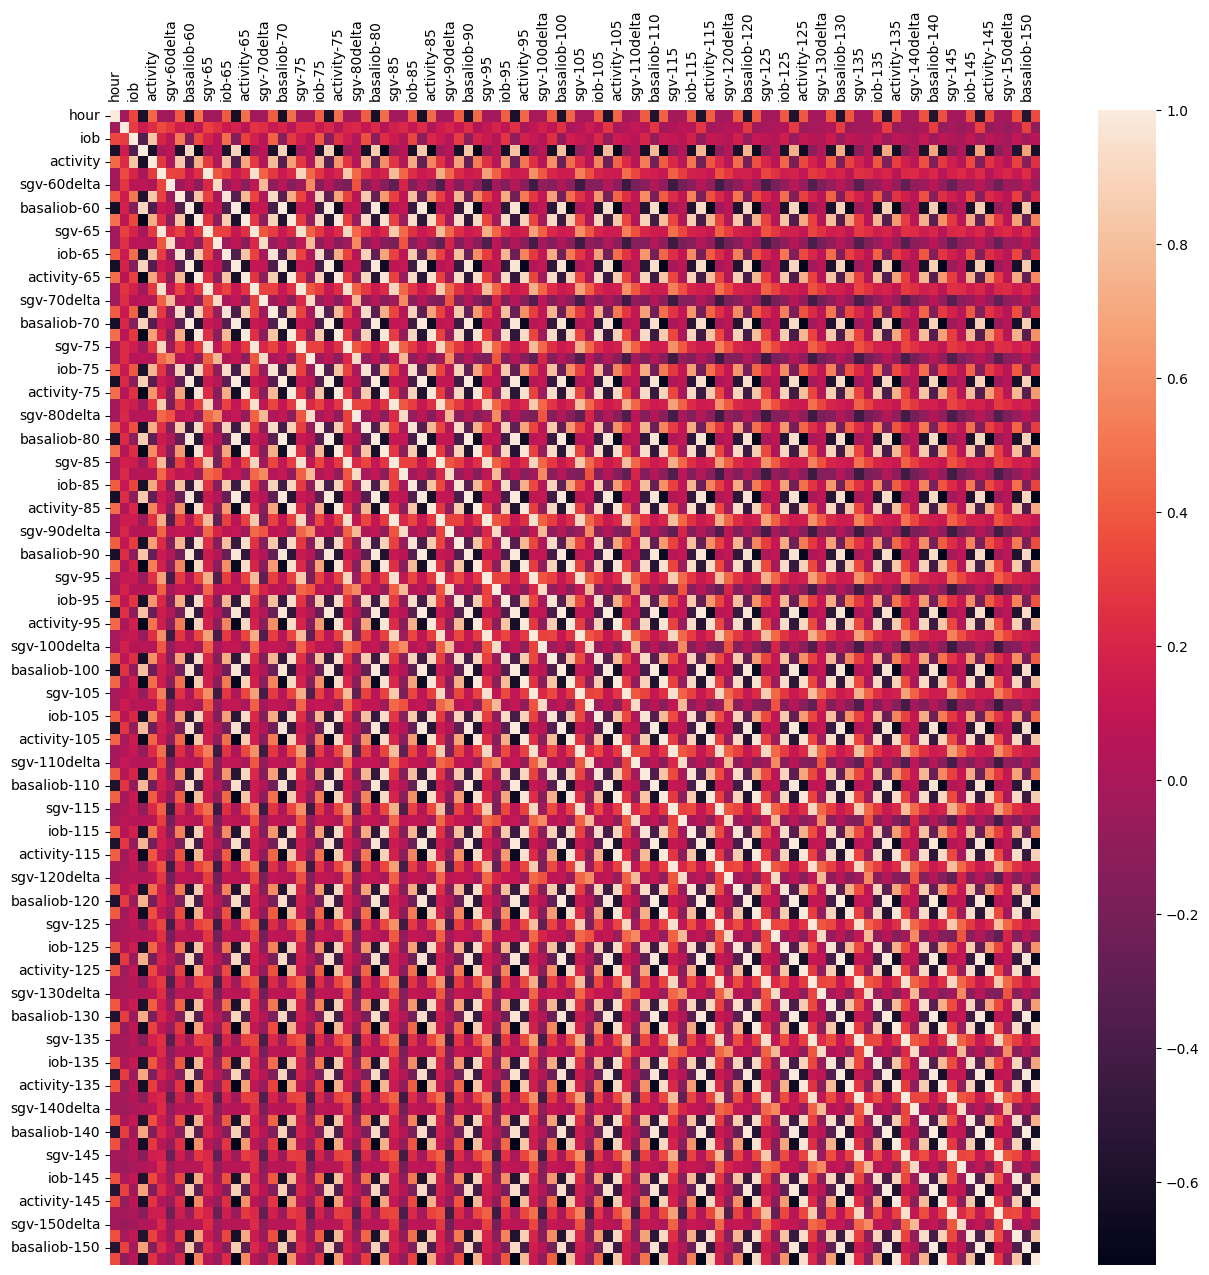

In [90]:
# Correlation matrix
display(normalized_dataset.corr(numeric_only = True))
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(normalized_dataset.corr(numeric_only = True), ax=ax)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=90, labelbottom = False, bottom=False, top = False, labeltop=True)

Here are some observation
* BasalIOB seems highest (-180 is .32), and somewhat high (activity-180 is .14)

In [56]:
# Pairplot
# sns.pairplot(normalized_dataset, x_vars=numerical_features, y_vars=numerical_features)

# Part 3 - Train Model


In [91]:
#@title Define plotting functions

def make_plots(df, feature_names, label_name, model_output, sample_size=200):

  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, rmse = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, rmse, fig)

  fig.show()
  return

def plot_loss_curve(epochs, rmse, fig):
  curve = px.line(x=epochs, y=rmse)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

def plot_model(df, features, weights, bias, fig):
  df['FARE_PREDICTED'] = bias[0]

  for index, feature in enumerate(features):
    df['FARE_PREDICTED'] = df['FARE_PREDICTED'] + weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='FARE_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "FARE_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)

  return

def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.


In [92]:

def build_model(my_learning_rate, num_features):
  """Create and compile a simple linear regression model."""
  # Most simple keras models are sequential.
  model = keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(keras.layers.Dense(units=1,
                                  input_shape=(num_features,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, df, features, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  # input_x = df.iloc[:,1:3].values
  # df[feature]
  history = model.fit(x=features,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse


def run_experiment(df, feature_names, label_name, learning_rate, epochs, batch_size):

  print('INFO: starting training experiment with features={} and label={}\n'.format(feature_names, label_name))

  num_features = len(feature_names)

  features = df.loc[:, feature_names].values
  label = df[label_name].values
  # display(features)
  # display(label)
  model = build_model(learning_rate, num_features)
  model_output = train_model(model, df, features, label, epochs, batch_size)

  print('\nSUCCESS: training experiment complete\n')
  print('{}'.format(model_info(feature_names, label_name, model_output)))
  make_plots(df, feature_names, label_name, model_output)

  return model

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


In [93]:
def create_samples(normalized_dataset, numerical_features, label):
  # Create indices at the 80th and 90th percentiles
  number_samples = len(normalized_dataset)
  index_80th = round(number_samples * 0.8)
  index_90th = index_80th + round(number_samples * 0.1)

  # Randomize order and split into train, validation, and test with a .8, .1, .1 split
  shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
  # display(shuffled_dataset.head())
  train_data = shuffled_dataset.iloc[0:index_80th]
  validation_data = shuffled_dataset.iloc[index_80th:index_90th]
  test_data = shuffled_dataset.iloc[index_90th:]

  x_train_continuous = train_data[numerical_features]
  # x_train_categorical = train_data[category_features]
  y_train = train_data[label]

  x_test_continuous = test_data[numerical_features]
  # x_test_categorical = test_data[category_features]
  y_test = test_data[label]

  x_validation_continuous = validation_data[numerical_features]
  # x_validation_categorical = validation_data[category_features]
  y_validation = validation_data[label]

  return x_train_continuous,  None,  y_train,  x_test_continuous,  None,  y_test,  x_validation_continuous,  None,  y_validation

x_train_continuous,  x_train_categorical,  y_train,  x_test_continuous,  x_test_categorical,  y_test,  x_validation_continuous,  x_validation_categorical,  y_validation = create_samples(normalized_dataset, numerical_features, "sgv")

In [94]:
#@title Try to better predict outcomes 30 minutes before
display(x_train_continuous.describe())
# display("The model needs to be better than 1 standard deviation of sgv-30: ", x_train_continuous.describe()["sgv-30"].loc["std"])
display("The model needs to be better than 1 standard deviation of sgv-60: ", x_train_continuous.describe()["sgv-60"].loc["std"])

,hour,sgv,iob,basaliob,activity,sgv-60,sgv-60delta,iob-60,basaliob-60,activity-60,...,sgv-145,sgv-145delta,iob-145,basaliob-145,activity-145,sgv-150,sgv-150delta,iob-150,basaliob-150,activity-150
count,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,...,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000
mean,-0.028231,-0.015075,-0.002884,0.000854,-0.003389,0.004553,-0.010569,-0.006369,0.007752,-0.014294,...,-0.015515,0.015687,-0.027246,0.003601,-0.025833,-0.017121,0.014642,-0.029474,0.002092,-0.025169
std,0.989706,0.997900,1.005928,1.010420,1.006135,0.989361,1.011162,0.996227,1.009613,0.997877,...,0.997222,0.971358,0.973150,1.004026,0.984263,0.995149,0.951624,0.973134,1.004100,0.984465
min,-1.632925,-2.719382,-1.302542,-1.732845,-1.348475,-2.700877,-8.238695,-1.302270,-1.719628,-1.357379,...,-2.676106,-8.240380,-1.302531,-1.718174,-1.362330,-2.676155,-7.583937,-1.303076,-1.718723,-1.363533
25%,-0.912299,-0.752702,-0.789041,-0.797619,-0.900610,-0.684459,-0.435523,-0.783608,-0.807392,-0.900406,...,-0.729168,-0.401328,-0.790157,-0.818553,-0.899226,-0.701949,-0.413489,-0.790489,-0.823104,-0.900302
50%,-0.047548,-0.071927,-0.358826,-0.203011,-0.185932,-0.049660,0.052879,-0.349211,-0.196668,-0.205425,...,-0.080188,0.078204,-0.353712,-0.216914,-0.199844,-0.062160,0.077337,-0.361602,-0.217993,-0.191276
75%,0.817203,0.646667,0.658485,0.887331,0.736002,0.659820,0.523716,0.614343,0.912277,0.737082,...,0.614494,0.552780,0.568440,0.861677,0.686197,0.614188,0.549405,0.561507,0.863342,0.676099
max,1.681954,3.937075,3.608051,2.057044,2.911005,3.871153,3.720063,3.628814,2.056081,2.907705,...,3.722283,3.463674,3.237575,2.077449,2.871764,3.612055,3.696961,3.403997,2.080156,2.871716


'The model needs to be better than 1 standard deviation of sgv-60: '

0.9893605040600133

In [95]:
#@title Code - Experiment 3 - multidimensional (sgv-?, and hour)

# The following variables are the hyperparameters.
learning_rate = 0.0005
epochs = 500
batch_size = 50

features_test = []
for min in range(60, 151, delta):
  features_test.append(f"sgv-{min}")
  features_test.append(f"sgv-{min}delta")
  features_test.append(f"iob-{min}")
  features_test.append(f"basaliob-{min}")
  features_test.append(f"activity-{min}")
display(features_test)
label = 'sgv'

model_all = run_experiment(x_train_continuous.dropna(), features_test, label, learning_rate, epochs, batch_size)

['sgv-60',
 'sgv-60delta',
 'iob-60',
 'basaliob-60',
 'activity-60',
 'sgv-65',
 'sgv-65delta',
 'iob-65',
 'basaliob-65',
 'activity-65',
 'sgv-70',
 'sgv-70delta',
 'iob-70',
 'basaliob-70',
 'activity-70',
 'sgv-75',
 'sgv-75delta',
 'iob-75',
 'basaliob-75',
 'activity-75',
 'sgv-80',
 'sgv-80delta',
 'iob-80',
 'basaliob-80',
 'activity-80',
 'sgv-85',
 'sgv-85delta',
 'iob-85',
 'basaliob-85',
 'activity-85',
 'sgv-90',
 'sgv-90delta',
 'iob-90',
 'basaliob-90',
 'activity-90',
 'sgv-95',
 'sgv-95delta',
 'iob-95',
 'basaliob-95',
 'activity-95',
 'sgv-100',
 'sgv-100delta',
 'iob-100',
 'basaliob-100',
 'activity-100',
 'sgv-105',
 'sgv-105delta',
 'iob-105',
 'basaliob-105',
 'activity-105',
 'sgv-110',
 'sgv-110delta',
 'iob-110',
 'basaliob-110',
 'activity-110',
 'sgv-115',
 'sgv-115delta',
 'iob-115',
 'basaliob-115',
 'activity-115',
 'sgv-120',
 'sgv-120delta',
 'iob-120',
 'basaliob-120',
 'activity-120',
 'sgv-125',
 'sgv-125delta',
 'iob-125',
 'basaliob-125',
 'activ

INFO: starting training experiment with features=['sgv-60', 'sgv-60delta', 'iob-60', 'basaliob-60', 'activity-60', 'sgv-65', 'sgv-65delta', 'iob-65', 'basaliob-65', 'activity-65', 'sgv-70', 'sgv-70delta', 'iob-70', 'basaliob-70', 'activity-70', 'sgv-75', 'sgv-75delta', 'iob-75', 'basaliob-75', 'activity-75', 'sgv-80', 'sgv-80delta', 'iob-80', 'basaliob-80', 'activity-80', 'sgv-85', 'sgv-85delta', 'iob-85', 'basaliob-85', 'activity-85', 'sgv-90', 'sgv-90delta', 'iob-90', 'basaliob-90', 'activity-90', 'sgv-95', 'sgv-95delta', 'iob-95', 'basaliob-95', 'activity-95', 'sgv-100', 'sgv-100delta', 'iob-100', 'basaliob-100', 'activity-100', 'sgv-105', 'sgv-105delta', 'iob-105', 'basaliob-105', 'activity-105', 'sgv-110', 'sgv-110delta', 'iob-110', 'basaliob-110', 'activity-110', 'sgv-115', 'sgv-115delta', 'iob-115', 'basaliob-115', 'activity-115', 'sgv-120', 'sgv-120delta', 'iob-120', 'basaliob-120', 'activity-120', 'sgv-125', 'sgv-125delta', 'iob-125', 'basaliob-125', 'activity-125', 'sgv-130',

This seems to be very good? RMSE is ~.6 for svg-30, or .8 for svg-60, which is far less than the STD of ~1

# Part 4 - Validate Model


---


## Use the model to make predictions

Now that you have a trained model, you can use the model to make predictions. In practice, you should make predictions on examples that are not used during training. However, for this exercise, you'll just work with a subset of the same training dataset. In another Colab exercise you will explore ways to make predictions on examples not used in training.

In [96]:
#@title Code - Define functions to make predictions

def build_batch(df, batch_size):
  batch = df.sample(n=batch_size).copy()
  batch.set_index(np.arange(batch_size), inplace=True)
  return batch

def predict_fare(model, features, train_df, test_df, label, label_mean, label_std):
  # batch = build_batch(df, batch_size)
  display(label_mean)
  test_df.set_index(np.arange(len(test_df)), inplace=True)
  predicted_values = model.predict_on_batch(x=test_df.loc[:, features].values)

  data = {"PREDICTED_SGV": [], "OBSERVED_SGV": [], "L1_LOSS": [],
          features[0]: [], features[1]: []}
  for i in range(len(test_df)):
    predicted = (predicted_values[i][0] * label_std) + label_mean
    observed = (test_df.at[i, label] * label_std) + label_mean
    data["PREDICTED_SGV"].append(predicted)
    data["OBSERVED_SGV"].append(observed)
    data["L1_LOSS"].append(abs(observed - predicted))
    data[features[0]].append(test_df.at[i, features[0]])
    data[features[1]].append("{:.2f}".format(test_df.at[i, features[1]]))

  output_df = pd.DataFrame(data)
  return output_df

def show_predictions(output):
  header = "-" * 80
  banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
  print(banner)

  print(output)
  return

111.90179717586649

Text(0.5, 1.0, 'SGV-60 vs SGV')

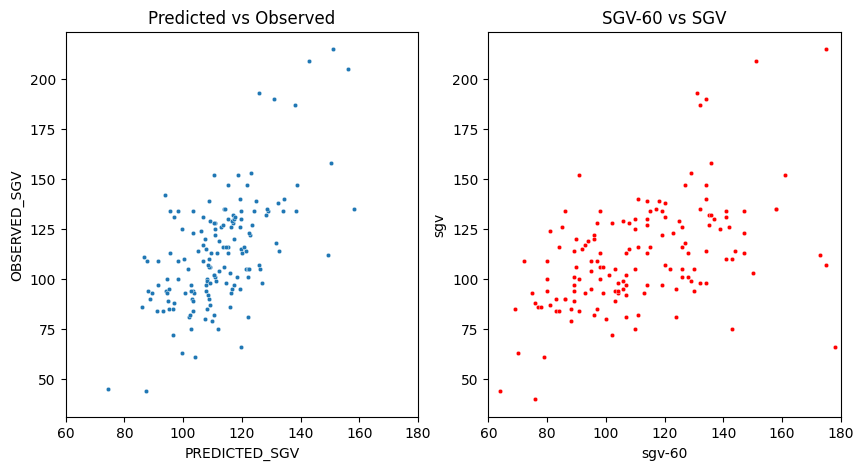

In [98]:
#@title Code - Make predictions

# pd.set_option('display.max_rows', 500)
output = predict_fare(model_all, features_test, x_train_continuous, x_test_continuous, label, feature_mean[label], feature_std[label])
# show_predictions(output)

fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(data=output, x="PREDICTED_SGV", y="OBSERVED_SGV", ax=axes[0], s=10)
axes[0].set_xlim(60,180)
axes[0].set_title("Predicted vs Observed")

x_test_continuous_orig = x_test_continuous[["sgv", "sgv-60"]]
x_test_continuous_orig["sgv"] = (x_test_continuous_orig["sgv"] * feature_std["sgv"]) + feature_mean["sgv"]
x_test_continuous_orig["sgv-60"] = (x_test_continuous_orig["sgv-60"] * feature_std["sgv-60"]) + feature_mean["sgv-60"]
sns.scatterplot(data=x_test_continuous_orig, x="sgv-60", y="sgv", ax=axes[1], color='red', s=10)
axes[1].set_xlim(60,180)
axes[1].set_title("SGV-60 vs SGV")